In [13]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# 파일 불러오기

In [14]:
data_merge = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\ver_3_merge_data.csv")
data_merge

,base_date,emd_cd,korean,long_term_frgn,short_term_frgn,resident,card_cnt,card_amt,waste_cnt,detached,apt,town,multiplex,commercial_building,distancing,waste_amt
0,2019-11-30,50110250,7.321788e+06,469689.3527,129161.4006,25149,267.380645,9586590.265,620,60578,58244,18880,28829,3900,0.000000,2279550
1,2019-12-31,50110250,6.915173e+06,482920.2385,122124.6609,25080,266.814465,9621756.255,8178,60578,58244,18880,28829,3900,0.000000,31493650
2,2020-01-31,50110250,7.476137e+06,587299.9640,112758.3034,25076,257.604430,9648302.136,13042,5542,954,1085,608,277,0.000000,49632850
3,2020-02-29,50110250,5.561978e+06,559439.3959,60252.7989,25021,249.621160,8760701.457,12264,5542,954,1085,608,277,0.000000,46197050
4,2020-03-31,50110250,6.094369e+06,714445.0812,29661.4429,24942,261.877023,8979547.945,14316,5542,954,1085,608,277,0.000000,52561750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,4.321265e+06,109325.4866,280.6159,4173,65.216000,2463788.712,4563,1023,0,219,39,29,1.750000,15566250
1630,2021-03-31,50130620,4.744309e+06,118258.8891,1475.8404,4178,67.700000,2572585.700,4920,1023,0,219,39,29,1.500000,17300600
1631,2021-04-30,50130620,5.236706e+06,129227.7480,1283.0997,4161,68.642336,2473174.901,5256,1023,0,219,39,29,1.500000,17646850
1632,2021-05-31,50130620,5.805413e+06,144213.2650,1212.2652,4178,69.333333,2864493.949,6346,1023,0,219,39,29,1.532258,19494750


In [15]:
data_merge = data_merge.drop(['short_term_frgn'], 1)
data_merge

,base_date,emd_cd,korean,long_term_frgn,resident,card_cnt,card_amt,waste_cnt,detached,apt,town,multiplex,commercial_building,distancing,waste_amt
0,2019-11-30,50110250,7.321788e+06,469689.3527,25149,267.380645,9586590.265,620,60578,58244,18880,28829,3900,0.000000,2279550
1,2019-12-31,50110250,6.915173e+06,482920.2385,25080,266.814465,9621756.255,8178,60578,58244,18880,28829,3900,0.000000,31493650
2,2020-01-31,50110250,7.476137e+06,587299.9640,25076,257.604430,9648302.136,13042,5542,954,1085,608,277,0.000000,49632850
3,2020-02-29,50110250,5.561978e+06,559439.3959,25021,249.621160,8760701.457,12264,5542,954,1085,608,277,0.000000,46197050
4,2020-03-31,50110250,6.094369e+06,714445.0812,24942,261.877023,8979547.945,14316,5542,954,1085,608,277,0.000000,52561750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,4.321265e+06,109325.4866,4173,65.216000,2463788.712,4563,1023,0,219,39,29,1.750000,15566250
1630,2021-03-31,50130620,4.744309e+06,118258.8891,4178,67.700000,2572585.700,4920,1023,0,219,39,29,1.500000,17300600
1631,2021-04-30,50130620,5.236706e+06,129227.7480,4161,68.642336,2473174.901,5256,1023,0,219,39,29,1.500000,17646850
1632,2021-05-31,50130620,5.805413e+06,144213.2650,4178,69.333333,2864493.949,6346,1023,0,219,39,29,1.532258,19494750


# xgboost 모델링

In [16]:
X_features = data_merge.loc[:, ['korean', 'long_term_frgn', 'resident', 
                                'card_cnt', 'card_amt', 'waste_cnt',
                                'detached', 'apt', 'town', 'multiplex', 'commercial_building', 'distancing']]
y_label = data_merge.loc[:, 'waste_amt']

In [17]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(1307, 12) (327, 12)


In [18]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [19]:
# max_depth = 3, 학습률은 0.1, 목적함수(objective)는 reg:linear(회귀)
# 오류함수의 평가성능지표는 rmse
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 7,
         'eta' : 0.1, 
         'objective' : 'reg:linear',
         'eval_metric' : 'rmsle',
         'early_stoppings' : 100 }
num_rounds = 1000

In [20]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[12:58:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmsle:2.31301	eval-rmsle:2.31622
[1]	train-rmsle:1.67145	eval-rmsle:1.67309
[2]	train-rmsle:1.31492	eval-rmsle:1.31776
[3]	train-rmsle:1.07751	eval-rmsle:1.07796
[4]	train-rmsle:0.90355	eval-rmsle:0.90550
[5]	train-rmsle:0.76858	eval-rmsle:0.77028
[6]	train-rmsle:0.66104	eval-rmsle:0.66300
[7]	train-rmsle:0.57426	eval-rmsle:0.57765
[8]	train-rmsle:0.50179	eval-rmsle:0.50574
[9]	train-rmsle:0.44103	eval-rmsle:0.4468

[172]	train-rmsle:0.02518	eval-rmsle:0.08026
[173]	train-rmsle:0.02518	eval-rmsle:0.08025
[174]	train-rmsle:0.02508	eval-rmsle:0.08024
[175]	train-rmsle:0.02508	eval-rmsle:0.08024
[176]	train-rmsle:0.02468	eval-rmsle:0.08026
[177]	train-rmsle:0.02446	eval-rmsle:0.08024
[178]	train-rmsle:0.02434	eval-rmsle:0.08020
[179]	train-rmsle:0.02412	eval-rmsle:0.08020
[180]	train-rmsle:0.02364	eval-rmsle:0.08009
[181]	train-rmsle:0.02350	eval-rmsle:0.08008
[182]	train-rmsle:0.02329	eval-rmsle:0.08018
[183]	train-rmsle:0.02297	eval-rmsle:0.08016
[184]	train-rmsle:0.02284	eval-rmsle:0.08009
[185]	train-rmsle:0.02283	eval-rmsle:0.08010
[186]	train-rmsle:0.02283	eval-rmsle:0.08010
[187]	train-rmsle:0.02270	eval-rmsle:0.08010
[188]	train-rmsle:0.02260	eval-rmsle:0.08004
[189]	train-rmsle:0.02258	eval-rmsle:0.08001
[190]	train-rmsle:0.02243	eval-rmsle:0.08002
[191]	train-rmsle:0.02193	eval-rmsle:0.07997
[192]	train-rmsle:0.02193	eval-rmsle:0.07996
[193]	train-rmsle:0.02155	eval-rmsle:0.07988
[194]	trai

[355]	train-rmsle:0.01005	eval-rmsle:0.07988
[356]	train-rmsle:0.01000	eval-rmsle:0.07988
[357]	train-rmsle:0.01000	eval-rmsle:0.07988
[358]	train-rmsle:0.00996	eval-rmsle:0.07991
[359]	train-rmsle:0.00984	eval-rmsle:0.07992
[360]	train-rmsle:0.00980	eval-rmsle:0.07991
[361]	train-rmsle:0.00970	eval-rmsle:0.07991
[362]	train-rmsle:0.00968	eval-rmsle:0.07995
[363]	train-rmsle:0.00977	eval-rmsle:0.07994
[364]	train-rmsle:0.00969	eval-rmsle:0.07994
[365]	train-rmsle:0.00961	eval-rmsle:0.07995
[366]	train-rmsle:0.00956	eval-rmsle:0.07994
[367]	train-rmsle:0.00956	eval-rmsle:0.07994
[368]	train-rmsle:0.00949	eval-rmsle:0.07994
[369]	train-rmsle:0.00946	eval-rmsle:0.07993
[370]	train-rmsle:0.00944	eval-rmsle:0.07992
[371]	train-rmsle:0.00944	eval-rmsle:0.07992
[372]	train-rmsle:0.00943	eval-rmsle:0.07993
[373]	train-rmsle:0.00943	eval-rmsle:0.07993
[374]	train-rmsle:0.00941	eval-rmsle:0.07992
[375]	train-rmsle:0.00933	eval-rmsle:0.07992
[376]	train-rmsle:0.00933	eval-rmsle:0.07991
[377]	trai

[538]	train-rmsle:0.00379	eval-rmsle:0.07988
[539]	train-rmsle:0.00377	eval-rmsle:0.07988
[540]	train-rmsle:0.00377	eval-rmsle:0.07988
[541]	train-rmsle:0.00371	eval-rmsle:0.07988
[542]	train-rmsle:0.00371	eval-rmsle:0.07988
[543]	train-rmsle:0.00371	eval-rmsle:0.07988
[544]	train-rmsle:0.00369	eval-rmsle:0.07988
[545]	train-rmsle:0.00366	eval-rmsle:0.07988
[546]	train-rmsle:0.00366	eval-rmsle:0.07988
[547]	train-rmsle:0.00365	eval-rmsle:0.07988
[548]	train-rmsle:0.00365	eval-rmsle:0.07988
[549]	train-rmsle:0.00364	eval-rmsle:0.07988
[550]	train-rmsle:0.00364	eval-rmsle:0.07988
[551]	train-rmsle:0.00364	eval-rmsle:0.07988
[552]	train-rmsle:0.00364	eval-rmsle:0.07988
[553]	train-rmsle:0.00362	eval-rmsle:0.07988
[554]	train-rmsle:0.00361	eval-rmsle:0.07988
[555]	train-rmsle:0.00360	eval-rmsle:0.07988
[556]	train-rmsle:0.00355	eval-rmsle:0.07987
[557]	train-rmsle:0.00354	eval-rmsle:0.07988
[558]	train-rmsle:0.00350	eval-rmsle:0.07987
[559]	train-rmsle:0.00349	eval-rmsle:0.07987
[560]	trai

[721]	train-rmsle:0.00172	eval-rmsle:0.07987
[722]	train-rmsle:0.00171	eval-rmsle:0.07987
[723]	train-rmsle:0.00171	eval-rmsle:0.07987
[724]	train-rmsle:0.00171	eval-rmsle:0.07987
[725]	train-rmsle:0.00170	eval-rmsle:0.07987
[726]	train-rmsle:0.00170	eval-rmsle:0.07987
[727]	train-rmsle:0.00168	eval-rmsle:0.07987
[728]	train-rmsle:0.00168	eval-rmsle:0.07987
[729]	train-rmsle:0.00165	eval-rmsle:0.07987
[730]	train-rmsle:0.00164	eval-rmsle:0.07987
[731]	train-rmsle:0.00164	eval-rmsle:0.07987
[732]	train-rmsle:0.00163	eval-rmsle:0.07986
[733]	train-rmsle:0.00163	eval-rmsle:0.07986
[734]	train-rmsle:0.00163	eval-rmsle:0.07986
[735]	train-rmsle:0.00162	eval-rmsle:0.07986
[736]	train-rmsle:0.00162	eval-rmsle:0.07986
[737]	train-rmsle:0.00162	eval-rmsle:0.07986
[738]	train-rmsle:0.00162	eval-rmsle:0.07987
[739]	train-rmsle:0.00161	eval-rmsle:0.07987
[740]	train-rmsle:0.00161	eval-rmsle:0.07987
[741]	train-rmsle:0.00161	eval-rmsle:0.07987
[742]	train-rmsle:0.00161	eval-rmsle:0.07987
[743]	trai

[904]	train-rmsle:0.00058	eval-rmsle:0.07986
[905]	train-rmsle:0.00058	eval-rmsle:0.07986
[906]	train-rmsle:0.00057	eval-rmsle:0.07986
[907]	train-rmsle:0.00057	eval-rmsle:0.07986
[908]	train-rmsle:0.00056	eval-rmsle:0.07985
[909]	train-rmsle:0.00056	eval-rmsle:0.07985
[910]	train-rmsle:0.00056	eval-rmsle:0.07985
[911]	train-rmsle:0.00056	eval-rmsle:0.07985
[912]	train-rmsle:0.00056	eval-rmsle:0.07985
[913]	train-rmsle:0.00056	eval-rmsle:0.07985
[914]	train-rmsle:0.00056	eval-rmsle:0.07985
[915]	train-rmsle:0.00055	eval-rmsle:0.07985
[916]	train-rmsle:0.00055	eval-rmsle:0.07985
[917]	train-rmsle:0.00055	eval-rmsle:0.07985
[918]	train-rmsle:0.00054	eval-rmsle:0.07985
[919]	train-rmsle:0.00054	eval-rmsle:0.07985
[920]	train-rmsle:0.00054	eval-rmsle:0.07985
[921]	train-rmsle:0.00054	eval-rmsle:0.07985
[922]	train-rmsle:0.00054	eval-rmsle:0.07985
[923]	train-rmsle:0.00054	eval-rmsle:0.07985
[924]	train-rmsle:0.00053	eval-rmsle:0.07985
[925]	train-rmsle:0.00053	eval-rmsle:0.07985
[926]	trai

# 예측하기

In [21]:
pred_probs = xgb_model.predict(dtest)
pred_probs

array([1.16112660e+07, 1.90160048e+08, 2.55905880e+07, 2.33765584e+08,
       4.50948440e+07, 3.62016280e+07, 6.64964840e+07, 3.92593360e+07,
       9.98167840e+07, 1.00786864e+08, 1.01247352e+08, 1.05630552e+08,
       5.94923480e+07, 3.21816760e+07, 4.57469480e+07, 4.67261800e+07,
       3.50366800e+07, 2.53523872e+08, 5.32289440e+07, 6.95566880e+07,
       5.12337840e+07, 8.80174400e+07, 5.53848840e+07, 4.09828800e+07,
       5.12329880e+07, 3.11817680e+07, 3.62538720e+07, 2.10272400e+07,
       3.30447000e+07, 5.04962640e+07, 2.63852180e+07, 3.95768720e+07,
       6.06551680e+07, 1.44182080e+08, 1.65112960e+07, 1.09718270e+07,
       1.10090992e+08, 2.05472000e+08, 1.55416540e+07, 9.34869280e+07,
       3.97274720e+07, 2.99699580e+07, 1.53071690e+07, 7.19507600e+07,
       2.48478880e+07, 2.17269760e+07, 3.72491850e+06, 1.01218552e+08,
       4.18354320e+07, 1.55684570e+07, 2.48562180e+07, 5.25887120e+07,
       6.21942600e+07, 1.45473620e+07, 3.54238040e+07, 3.03884820e+07,
      

In [22]:
pd.DataFrame(pred_probs)

,0
0,11611266.0
1,190160048.0
2,25590588.0
3,233765584.0
4,45094844.0
...,...
322,44097896.0
323,19836772.0
324,39358664.0
325,106537808.0


# Feature Importance Plot

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

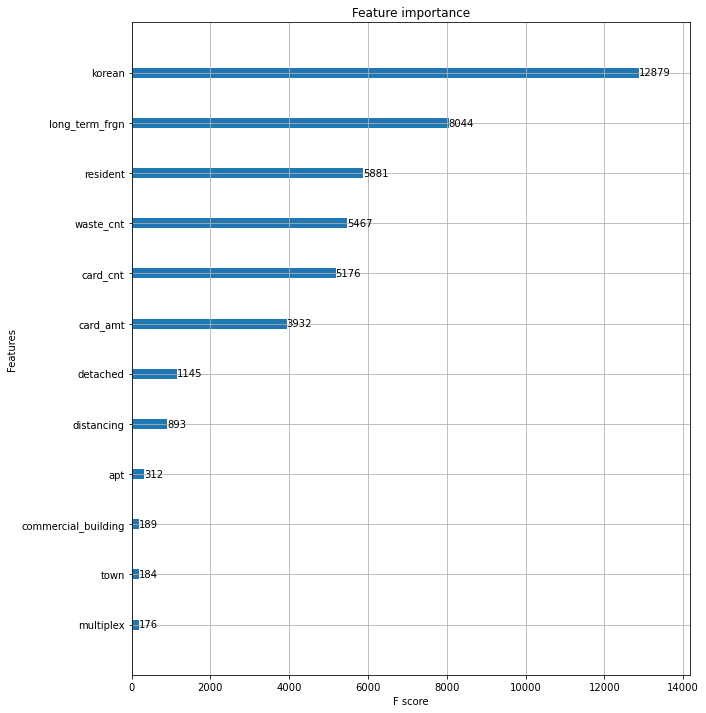

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)